# Lab 6: Random Forest Regression on Malagasy Mammal Traits

Jordan Sibley 

Date: 02/20/2025

### Introduction
 In Lab 5, we used functional trait data on bird species to predict their presence in a given climate type. This week we are using regression tree models on a similar dataset, this one on mammal species.  Our goal is to predict the total number of climate types each mammal species inhabits.

You will compare performance of a single decision tree with a tuned random forest to get a sense of the effectiveness of ensemble methods with optimized hyperparameter values.

There is a fair amount of missing data in this set, which can lead to low reliability of feature splits, increased overfitting, and decreased accuracy of tree models. You will address this issue with a combination of variable omission and imputation.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

### Step 1: Read data and retain a subset of the columns
Similar to last week, we will need to take some steps to get the data in a usable form. We again reformat the diet-related variable names to match this set: `Diet_Vertebrates`,
    `Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`. Then drop columns that are not relevant functional traits or climate type variables.   Next, drop any remaining  variables that have greater than 40% of the observations missing. Print the final dataframe shape. 
    
Note from slack: impute categorical variables using mode and numerical variables using knn

In [2]:
# Read in data, convert -999 values to NA, and rename columns  
dat = pd.read_csv("/courses/EDS232/Data/MamTraitData.csv", encoding="ISO-8859-1", na_values = '-999').rename(columns={
    'Diet: invertebrates': 'Diet_Invertebrates',
    'Diet: vertebrates': 'Diet_Vertebrates',
    'Diet: fruits': 'Diet_Fruits',
    'Diet: flower/nectar/pollen/gums': 'Diet_Flowers',
    'Diet: seeds': 'Diet_Seeds',
    'Diet: other plant materials': 'Diet_Plants',
    'Diet: scavenge; garbage; carrion; carcasses': 'Diet_Other'
})

# View shape of dataframe 
print(f"Shape of data frame: {dat.shape}")

# View which columns have 40% NA values 
print (f"Percent of column with NA values:\n {(dat.isna().sum())/214 * 100}") 
 
# Drop columns that have at least 40% NA values 
dat_clean = dat.dropna(thresh=(len(dat)*.6), axis=1)

# Print cleaned dataframe shape 
print(f"Final DataFrame shape: {dat_clean.shape}")

Shape of data frame: (214, 24)
Percent of column with NA values:
 AdultBodyMass          1.401869
CranialCapacity       79.906542
Diet_Invertebrates     7.009346
Diet_Vertebrates       7.009346
Diet_Fruits            7.009346
Diet_Flowers           7.009346
Diet_Seeds             7.009346
Diet_Plants            7.009346
Diet_Other             7.009346
HabitatBreadth        12.149533
ActivityCycle         10.280374
ForagingStratum       11.214953
GestationLength       55.140187
LitterSize            38.785047
InterbirthInterval    60.280374
HomeRange             70.560748
PopulationDensity     76.168224
SocialGrpSize         63.551402
Longevity             61.214953
Dry                    0.000000
Humid                  0.000000
Montane                0.000000
Subarid                0.000000
Subhumid               0.000000
dtype: float64
Final DataFrame shape: (214, 17)


### Step 2: Imputation with KNN
Now impute the values of the missing data in the remaining numeric columns using k-nearest neighbors with `KNNImputer()`. Use the 5 nearest neighbors. This allows us to implement the knn algorithm to predict the missing values for an observation based on similar complete observations.Perform and print a check to ensure that there are no more NA values. 

In [3]:
# View data types of each columns 
dat_clean.dtypes

AdultBodyMass         float64
Diet_Invertebrates     object
Diet_Vertebrates       object
Diet_Fruits            object
Diet_Flowers           object
Diet_Seeds             object
Diet_Plants            object
Diet_Other             object
HabitatBreadth        float64
ActivityCycle         float64
ForagingStratum       float64
LitterSize            float64
Dry                     int64
Humid                   int64
Montane                 int64
Subarid                 int64
Subhumid                int64
dtype: object

In [4]:
# Separate numerical and categorical columns 
categorical = dat_clean.select_dtypes(include = ['object']).columns 
numerical = dat_clean.select_dtypes(include = ['float64', 'int64']).columns

# Impute missing data of categorical variables using mode and numerical variables using knn
cat_imputer = SimpleImputer(strategy = "most_frequent")
num_imputer = KNNImputer(n_neighbors = 5)

dat_clean[categorical] = cat_imputer.fit_transform(dat_clean[categorical])
dat_clean[numerical] = num_imputer.fit_transform(dat_clean[numerical])

# Confirm no more NAs
print(dat_clean.isna().sum())

AdultBodyMass         0
Diet_Invertebrates    0
Diet_Vertebrates      0
Diet_Fruits           0
Diet_Flowers          0
Diet_Seeds            0
Diet_Plants           0
Diet_Other            0
HabitatBreadth        0
ActivityCycle         0
ForagingStratum       0
LitterSize            0
Dry                   0
Humid                 0
Montane               0
Subarid               0
Subhumid              0
dtype: int64


/opt/python/3.7.13/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/python/3.7.13/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


### Step 3: Create target variable and numerical encoding 
Create the target variable (`nClimates`) representing the  number of climates in which a species was present. Then finish preparing the data to be used in our models.

- Create a new column `nClimates` that combines the information of the five climate type variables
- Drop the original `Dry`, `Humid`, `Montane`, `Subarid`, and `Subhumid` columns
- Encode categorical variables
- Split the dataset into training and test sets. Use a random state of 808. 

In [5]:
# Create new column that adds up the number of climates present
dat_clean['nClimates'] = dat_clean[['Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid']].sum(axis=1)

# Drop original climate columns 
data = dat_clean.drop(columns=['Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid'])

# Encode categorical columns 
for col in categorical: 
    label_encoder = LabelEncoder()
    data[col] = label_encoder.fit_transform(data[col])

# Check results 
data.head()

/opt/python/3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,AdultBodyMass,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_Seeds,Diet_Plants,Diet_Other,HabitatBreadth,ActivityCycle,ForagingStratum,LitterSize,nClimates
0,78.0,1,0,1,1,0,1,0,1.0,2.0,3.0,1.000,3.0
1,1082.0,0,0,1,0,0,1,0,1.0,1.0,3.0,1.402,2.0
2,946.0,0,0,1,0,0,1,0,2.0,1.0,3.0,4.692,1.0
3,1180.0,0,0,1,0,0,1,0,2.0,1.0,3.0,1.010,4.0
4,1212.5,0,0,1,0,0,1,0,1.0,1.0,3.0,1.540,3.0


In [6]:
# Define features 
X = data.drop('nClimates', axis =1)
y = data['nClimates']

# Spilt data into training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.3, random_state=808)

### Step 4: Train a decision tree
Train a single decision tree to predict the number of climate types inhabited by each species.

- Train a `DecisionTreeRegressor`.  Let's apply a constraint on its growth by not allowing the tree to grow further than 5 levels. Use a random state of 808. 
- Make predictions
- Visualize the decision tree using `plot_tree`
- Evaluate and print its performance using mse

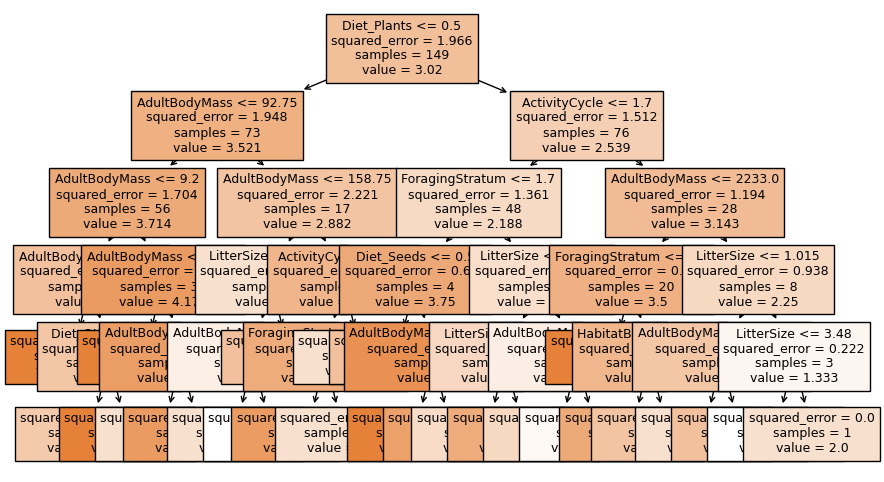

In [7]:
# Create decision tree, initialize regressor 
dtree = DecisionTreeRegressor(max_depth=5, random_state=808)

# Fit decision tree 
dtree.fit(X_train, y_train)

# Make predictions 
y_pred = dtree.predict(X_test)

# Plot decision tree 
plt.figure(figsize = (10,6))
plot_tree(dtree, filled = True, feature_names=X.columns, fontsize=9)
plt.show()

In [8]:
# Calculate mean squared error 
dtree_mse = mean_squared_error(y_test, y_pred)
print(f"Decision tree mean squared error: {dtree_mse}")

Decision tree mean squared error: 2.0601525141415333


Based on the way this tree looks, what would you guess the most important variable to be?

Based on the plot of the decision tree, I would say that the feature Diet_Plants is the most important variable as it is the root node, which determines the first spilt. 

### Step 5: Random forest with hyperparameter tuning
Now we'll use a more sophisticated ensemble approach where we optimize the values of key hyperparameters that govern tree growth.

- Define a parameter grid that includes the follow parameters and values:
  -  (sqrt(p), 6, and no set #) of the number of features to try at each split
  -  (50, 100, 200) total trees (learners)
  -  a maximum tree depth of (3,4,5,6,7)
  -  (2,5,10) minimum samples per split
  -  (1,2,4) minimum samples per leaf
  
- Use `GridSearchCV` with 5-fold cross-validation and mse (`neg_mean_squared_error`) to find the best combination of parameter values
- Train the best estimator.

In [9]:
# Define the parameter grid 
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 4, 5, 6, 7],
    "max_features": ["sqrt", 6, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Initialize Random forest 
rf = RandomForestRegressor(random_state=808)

# Identify best parameters
gs = GridSearchCV(rf, 
                param_grid = param_grid, 
                n_jobs = -1, 
                return_train_score = True,
                scoring="neg_mean_squared_error",
                cv =5)
# Fit Random Forest with best parameters 
gs.fit(X_train, y_train)

# Display best parameters 
gs.best_params_

{'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

In [10]:
# Train and fit RF using best params 
best_rf = RandomForestRegressor(**gs.best_params_, random_state=808)
best_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_split=5,
                      n_estimators=200, random_state=808)

### Step 6: Make predictions and evaluate random forest model
Use the optimized random forest model (`best_rf`) to predict the number of climates a species inhabits and analyze its performance.

- Use `best_rf` and `predict()` method on `X_test` to generate predictions
- Print the best set of parameter values using thte `best_params` method
- Compute and print the mse to evaluate model performance
- Extract feature importance from the trained random forest model
- Visualize feature importance using a bar plot

In [11]:
# Make predictions with best RF 
y_pred_best = best_rf.predict(X_test)

# Print best set of params 
print(f"Best parameters:\n{gs.best_params_}")
print(f"\nMean squared error: {mean_squared_error(y_pred_best, y_test):3f}")

Best parameters:
{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Mean squared error: 1.436256


In [12]:
# Determine feature importance 
feature_importance = best_rf.feature_importances_

# Create dataframe of feature importance 
importance_df = pd.DataFrame(zip(X_test.columns,
                                feature_importance),
                            columns = ["Feature", "Importance"])

# Sort data frame by importance 
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# View data frame 
importance_df

,Feature,Importance
0,AdultBodyMass,0.258363
11,LitterSize,0.171953
10,ForagingStratum,0.140860
6,Diet_Plants,0.100498
9,ActivityCycle,0.080432
8,HabitatBreadth,0.065634
1,Diet_Invertebrates,0.038459
3,Diet_Fruits,0.033763
5,Diet_Seeds,0.031706
4,Diet_Flowers,0.030888


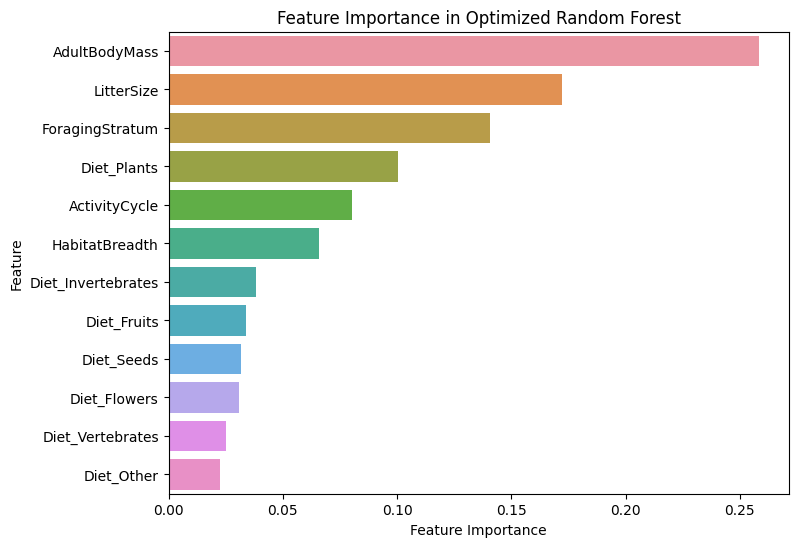

In [13]:
# Create bar plot to display important features 
plt.figure(figsize = (8, 6))
sns.barplot(data = importance_df,
           x = "Importance",
           y = "Feature")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Optimized Random Forest")
plt.show()

Which model had better accuracy, the single tree or the ensemble.  Interpret which traits have the most influence on species' climate adaptability.

The ensemble model had better results as shown by the lower mean squared error (1.43 versus the score of 2.06 of the single tree). The model reveals that the trait that has the most influence on species' climate adaptability is adult body mass, followed by liter size. 